In [64]:
import pandas as pd
import numpy as np
from pandas import DataFrame
import matplotlib.pyplot as plt

In [35]:
df = pd.read_csv('prediction_result.csv')
df.drop(columns=['Unnamed: 0'],inplace=True)
x=df['date']
originaly=df['origin']
predictiony0=df['close(t)']
predictiony1=df['close(t+1)']
df

,date,origin,close(t),close(t+1)
0,2019-03-03,132.313170,147.61539,143.85411
1,2019-03-04,127.364334,146.26158,140.84042
2,2019-03-05,137.620250,140.34738,135.42894
3,2019-03-06,138.857440,141.64143,138.26811
4,2019-03-07,138.031140,147.90184,144.13689
...,...,...,...,...
1453,2023-02-23,1651.026900,1708.97060,1659.11890
1454,2023-02-24,1608.825900,1692.76780,1649.87680
1455,2023-02-25,1594.292200,1684.01100,1635.51250
1456,2023-02-26,1639.418000,1652.56710,1611.48080


# 计算信号 (只计算测试集）
资产分2份，2天为一周期，每天都判断，如2天后的收盘价大于当前价则买一份，买信号发出2天后必卖一份，策略偏保守，最大回撤小，收益小

In [36]:
dataset = {'date':x,
           'close(t-1)':originaly,
       'close(t)':predictiony0,
       'close(t+1)':predictiony1}
df = DataFrame(dataset)
# df.set_index(['date'], inplace = True, drop=True) 
df['close(t+1)-close(t-1)'] = df['close(t+1)'] - df['close(t-1)']
df['isbuy'] = df['close(t+1)-close(t-1)'] > 0
df['issell'] = df['isbuy'].shift(2) #n_out=2
df['issell'].fillna(value= False, inplace=True)
df

,date,close(t-1),close(t),close(t+1),close(t+1)-close(t-1),isbuy,issell
0,2019-03-03,132.313170,147.61539,143.85411,11.540940,True,False
1,2019-03-04,127.364334,146.26158,140.84042,13.476086,True,False
2,2019-03-05,137.620250,140.34738,135.42894,-2.191310,False,True
3,2019-03-06,138.857440,141.64143,138.26811,-0.589330,False,True
4,2019-03-07,138.031140,147.90184,144.13689,6.105750,True,False
...,...,...,...,...,...,...,...
1453,2023-02-23,1651.026900,1708.97060,1659.11890,8.092000,True,True
1454,2023-02-24,1608.825900,1692.76780,1649.87680,41.050900,True,True
1455,2023-02-25,1594.292200,1684.01100,1635.51250,41.220300,True,True
1456,2023-02-26,1639.418000,1652.56710,1611.48080,-27.937200,False,True


# 计算仓位¶

In [37]:
initlocation = 0 #初始仓位为0
initUS = 2 #初始美元现金为2
maxlocation = 2 #满仓为2
def function(isbuy, issell):
    if issell and (not isbuy): return -1
    if isbuy and issell: return 0
    if (not isbuy) and (not issell): return 0
    if isbuy and (not issell): return 1

df['location action'] = df.apply(lambda x: function(x.isbuy, x.issell), axis = 1)
df['location status'] = df['location action'].expanding().sum()
df['location status'] = df['location status'] / df['location status'].max()
df

,date,close(t-1),close(t),close(t+1),close(t+1)-close(t-1),isbuy,issell,location action,location status
0,2019-03-03,132.313170,147.61539,143.85411,11.540940,True,False,1,0.5
1,2019-03-04,127.364334,146.26158,140.84042,13.476086,True,False,1,1.0
2,2019-03-05,137.620250,140.34738,135.42894,-2.191310,False,True,-1,0.5
3,2019-03-06,138.857440,141.64143,138.26811,-0.589330,False,True,-1,0.0
4,2019-03-07,138.031140,147.90184,144.13689,6.105750,True,False,1,0.5
...,...,...,...,...,...,...,...,...,...
1453,2023-02-23,1651.026900,1708.97060,1659.11890,8.092000,True,True,0,1.0
1454,2023-02-24,1608.825900,1692.76780,1649.87680,41.050900,True,True,0,1.0
1455,2023-02-25,1594.292200,1684.01100,1635.51250,41.220300,True,True,0,1.0
1456,2023-02-26,1639.418000,1652.56710,1611.48080,-27.937200,False,True,-1,0.5


# 计算资金曲线¶

In [46]:
df['cycle growth rate'] = df['close(t-1)'].diff()
df['cycle growth rate'] = df['cycle growth rate'].shift(-1)
df['cycle growth rate'].fillna(value=0, inplace=True)
df['cycle growth rate'] = df['cycle growth rate'] /  df['close(t-1)'] 
df['Asset cycle growth rate'] = df['location status'] * df['cycle growth rate']
df['cycle growth rate'] = df['cycle growth rate'].shift(1)
df['cycle growth rate'].fillna(value=0, inplace=True)
df['Asset cycle growth rate'] = df['Asset cycle growth rate'].shift(1)
df['Asset cycle growth rate'].fillna(value=0, inplace=True)
df['Asset cycle growth rate'] = df['Asset cycle growth rate'] + 1
df['Asset growth rate'] = df['Asset cycle growth rate'].cumprod()
df['ETH growth rate'] = (df['cycle growth rate']+1).cumprod()
df

,date,close(t-1),close(t),close(t+1),close(t+1)-close(t-1),isbuy,issell,location action,location status,cycle growth rate,Asset cycle growth rate,Asset growth rate,ETH growth rate
0,2019-03-03,132.313170,147.61539,143.85411,11.540940,True,False,1,0.5,0.000000,1.000000,1.000000,1.000000
1,2019-03-04,127.364334,146.26158,140.84042,13.476086,True,False,1,1.0,-0.037402,0.981299,0.981299,0.962598
2,2019-03-05,137.620250,140.34738,135.42894,-2.191310,False,True,-1,0.5,0.080524,1.080524,1.060317,1.040110
3,2019-03-06,138.857440,141.64143,138.26811,-0.589330,False,True,-1,0.0,0.008990,1.004495,1.065083,1.049460
4,2019-03-07,138.031140,147.90184,144.13689,6.105750,True,False,1,0.5,-0.005951,1.000000,1.065083,1.043215
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1453,2023-02-23,1651.026900,1708.97060,1659.11890,8.092000,True,True,0,1.0,0.004738,1.004738,5.620307,12.478175
1454,2023-02-24,1608.825900,1692.76780,1649.87680,41.050900,True,True,0,1.0,-0.025560,0.974440,5.476649,12.159227
1455,2023-02-25,1594.292200,1684.01100,1635.51250,41.220300,True,True,0,1.0,-0.009034,0.990966,5.427174,12.049384
1456,2023-02-26,1639.418000,1652.56710,1611.48080,-27.937200,False,True,-1,0.5,0.028305,1.028305,5.580788,12.390437


In [79]:
df['Asset net value'] = df['Asset growth rate'] * df['close(t-1)'][0]
df

,date,close(t-1),close(t),close(t+1),close(t+1)-close(t-1),isbuy,issell,location action,location status,cycle growth rate,Asset cycle growth rate,Asset growth rate,ETH growth rate,Asset net value
0,2019-03-03,132.313170,147.61539,143.85411,11.540940,True,False,1,0.5,0.000000,1.000000,1.000000,1.000000,132.313170
1,2019-03-04,127.364334,146.26158,140.84042,13.476086,True,False,1,1.0,-0.037402,0.981299,0.981299,0.962598,129.838752
2,2019-03-05,137.620250,140.34738,135.42894,-2.191310,False,True,-1,0.5,0.080524,1.080524,1.060317,1.040110,140.293919
3,2019-03-06,138.857440,141.64143,138.26811,-0.589330,False,True,-1,0.0,0.008990,1.004495,1.065083,1.049460,140.924532
4,2019-03-07,138.031140,147.90184,144.13689,6.105750,True,False,1,0.5,-0.005951,1.000000,1.065083,1.043215,140.924532
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1453,2023-02-23,1651.026900,1708.97060,1659.11890,8.092000,True,True,0,1.0,0.004738,1.004738,5.620307,12.478175,743.640578
1454,2023-02-24,1608.825900,1692.76780,1649.87680,41.050900,True,True,0,1.0,-0.025560,0.974440,5.476649,12.159227,724.632786
1455,2023-02-25,1594.292200,1684.01100,1635.51250,41.220300,True,True,0,1.0,-0.009034,0.990966,5.427174,12.049384,718.086649
1456,2023-02-26,1639.418000,1652.56710,1611.48080,-27.937200,False,True,-1,0.5,0.028305,1.028305,5.580788,12.390437,738.411803


# 绘制资金曲线¶

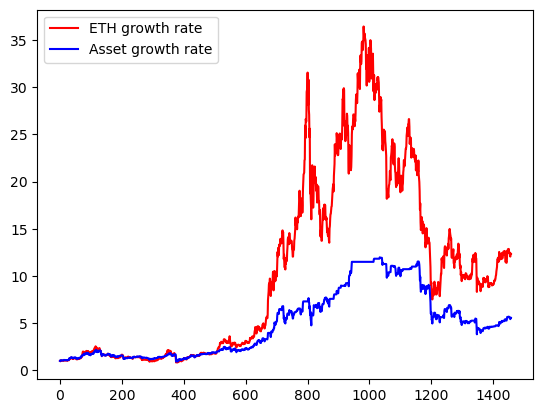

1453    12.478175
1454    12.159227
1455    12.049384
1456    12.390437
1457    12.345333
Name: ETH growth rate, dtype: float64
1453    5.620307
1454    5.476649
1455    5.427174
1456    5.580788
1457    5.570631
Name: Asset growth rate, dtype: float64


In [59]:
%matplotlib inline 
plt.figure()
plt.plot(df['ETH growth rate'].values.reshape(-1), 'r', label='ETH growth rate')
plt.plot(df['Asset growth rate'].values.reshape(-1), 'b', label='Asset growth rate')
# plt.plot(df['Asset net value'].values.reshape(-1), 'g', label='Asset net value')


plt.legend()
plt.show()
print(df['ETH growth rate'].tail())
print(df['Asset growth rate'].tail())

In [82]:
def performance_management(performance_return):
    sharpe = (performance_return['Asset growth rate'].mean() * np.sqrt(12) / performance_return.std())['Asset growth rate']
    withdraw = 0
    max_withdraw = 0
    DAYS = len(performance_return['date'])
    for i in range(DAYS):
        for j in range(i, DAYS):
            if performance_return['Asset net value'][j] < performance_return['Asset net value'][i]:
                withdraw = (performance_return['Asset net value'][i] - performance_return['Asset net value'][j]) / performance_return['Asset net value'][i]
            if withdraw > max_withdraw:
                max_withdraw = withdraw
    hpr = (performance_return['Asset net value'][DAYS - 1] - performance_return['Asset net value'][0]) / performance_return['Asset net value'][0]
    annual_vol = np.std(performance_return['Asset growth rate'])*np.sqrt(252)
    calmar_ratio = (hpr * 12 * 100 / (DAYS - 1))/max_withdraw
    print('Holding Period Return: %.2f%%' % (hpr * 100))
    print('Annual Return: %.2f%%' % (hpr * 12 * 100 / (DAYS - 1)))
    print('Annual Volatility: %.2f%%' % annual_vol)
    print('Annual Sharpe: %.2f' % sharpe)
    print('Maximum Withdraw: %.2f' % max_withdraw)
    print('Calmar Ratio: %.2f' % calmar_ratio)

In [83]:
performance_management(df)

/var/folders/lp/2qf3969x3rz9wd_rlf3gnzr00000gn/T/ipykernel_6546/680976941.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  sharpe = (performance_return['Asset growth rate'].mean() * np.sqrt(12) / performance_return.std())['Asset growth rate']


Holding Period Return: 457.06%
Annual Return: 3.76%
Annual Volatility: 55.60%
Annual Sharpe: 4.86
Maximum Withdraw: 0.68
Calmar Ratio: 5.53
